In [ ]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''
NEED TO REDO THE A/V CALCULATION

the UA term is estimated to be 0.116 J (s K)^-1.
Use these below for now as heats but there are equations also in the paper
smr: dH@298 = 206.1 kJ/mol
wgs: dH@298 = -41.15 kJ/mol
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m

h2Removal = 0 #change to 1 if there is removal of hydrogen

#gas flow constants
T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 * 60
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec

#rate equation constants
Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
F = 96485 #faradays constant
Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]


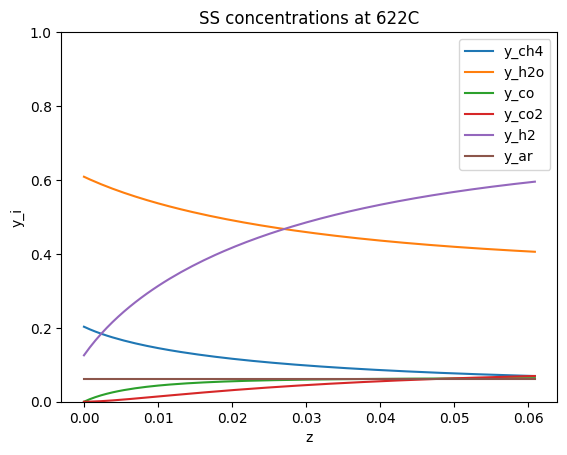

In [3]:
x_num = 80

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((6, x_num))

# init_guess[0, :] = 0.2
# init_guess[1, :] = 0.6  
# init_guess[2, :] = 0
# init_guess[3, :] = 0    
# init_guess[4, :] = 0.1

#what seems to me to be better guesses makes it worse

def odes(x, y): #dy/dt = f(x)
    #NEED TO ADJUST THIS. THESE ARE NOT CONCENTRATIONS, THEY ARE MOL FRACTIONS
    Cch4 = y[0]
    Ch2o = y[1]
    Cco = y[2]
    Cco2 = y[3]
    Ch2 = y[4]
    
    v = v0*(3*y0[0] - 2*Cch4)/y0[0] # v0*(1+2X)
    # print(len(v))

    rsmr = 2/R_outer*Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(Cch4*Ch2o-(P**2)*Cco*(Ch2**3)/Keqsmr)/Ctot
    rwgs = 2/R_outer*Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(Ch2o*Cco-Cco2*Ch2/Keqwgs)/Ctot
    rh2r = I/(2*F*L)/Ctot #have not confirmed if this is correct
    # print(len(rsmr))

    ch4 = (-rsmr)/v
    h2o = (-rsmr - rwgs)/v
    co = (rsmr - rwgs)/v
    co2 = (rwgs)/v
    h2 = (3*rsmr + rwgs + h2Removal*rh2r)/v
    ar = np.zeros(len(Cch4))
    
    return np.vstack([ch4, h2o, co, co2, h2, ar])

def bcs(yleft, yright):
    return np.array(yleft-y0)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=200) #look into using odeint. the ODEs are still. use the adam solver

plt.plot(soln.x, soln.y[0], label='y_ch4')
plt.plot(soln.x, soln.y[1], label='y_h2o')
plt.plot(soln.x, soln.y[2], label='y_co')
plt.plot(soln.x, soln.y[3], label='y_co2')
plt.plot(soln.x, soln.y[4], label='y_h2')
plt.plot(soln.x, soln.y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS concentrations at ' + str(T-273) + 'C')
plt.legend()